<a href="https://colab.research.google.com/github/MarciaFG/scimobility/blob/main/FOR3_transformation_index_for_2007_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic transformation project (2007-2022)**
**Author:** Marcia R. Ferreira (Complexity Science Hub Vienna & TU Wien)
- **Inputs:** 

1. **CWTS SQL Server** [dimensions_2022jun], up to date until 30-6-2022 08:27:51
2. **CWTS Publication-level classification system**: Meso-fields level [dimensions_2022jun_classification]
3. **Dimension reduction-based clustering**: Laplacian matrix contructed from meso-field level topic matrix and second eigenvector of the matrix
4. **Dimensions database on BigQuery**, real time up to date
5. **Organisations indicators** calculated based on the CWTS SQL Server DB

- **Outputs:**


**Changes applied to the data:** \
 1 - Removed all research stays of lenght 2 \
 2 - Removed all researchers with only 1 skill \
 3 - To display the ranks restrict institutions to the top 100 with bar charts with error bars \
 4 - In the overall analysis set an additional threshold at the institutional level, i.e.,  top 1000 high impact universities \
 5 - Choose five fields instead of 22

 6 - Do a box plot for the top 100 universities sorted according to the mean, stdev \
 7 - Set a threshold at the individual level: exclude researchers with 1 skill, then 2-3, then 4-5 \


### Initialization and drivers

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Fri May  5 07:50:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
#!pip install pynput
#pip install plotly==5.4.0
!pip install patool

# main libraries
import psutil
import humanize
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import requests
import torch
import nltk
import GPUtil as GPU
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# plotting
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# Google big query
from google.cloud import bigquery
from google.colab import files
%load_ext google.colab.data_table
%load_ext google.cloud.bigquery

# mount drive
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7408 sha256=a4fceaa7a0205a8190653f2e11beb7c5514db998adb48ee4a7e68a00892482f8
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 9.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# Provide your credentials to the runtime
#from google.colab import auth
#auth.authenticate_user()
#print('Authenticated')

# declare your project 
#project_id = "cshdimensionstest"

### Data imports

In [ ]:
#!ls "/content/drive/My Drive"

In [3]:
import patoolib
import tempfile
import os

# unzip the files exported from SQL Server
# Path of the zip file in Google Drive
zip_path = "/content/drive/My Drive/TRANSFORMATION/data_export.zip"

# Name of the CSV file(s) inside the zip
csv_file_names = [  "spectral_meso_clusters.csv"
                  , "for_division_labels.csv"
                  , "grid_ranks.csv"
                  , "trajectories_au_fourfive_skill.csv"
                  , "trajectories_au_morethanfive_skill.csv"
                  , "trajectories_au_single_skill.csv"
                  , "trajectories_au_twothree_skill.csv"]

# Separator character to use in the CSV files
separator = ";"

# Extract the zip file to a temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    patoolib.extract_archive(zip_path, outdir=tmpdir)
    
    # Load each CSV file into its own dataframe
    dfs = []
    for csv_file_name in csv_file_names:
        csv_file_path = os.path.join(tmpdir, csv_file_name)
        try:
            df = pd.read_csv(csv_file_path, sep=separator, encoding='utf-8', header= None, decimal=".")
            dfs.append(df)
        except pd.errors.ParserError:
            print(f"Error loading {csv_file_name}: Skipping...")

################################################################################

# Print the first few rows of each dataframe
for i, df in enumerate(dfs):
    print(f"Dataframe {i}:")
    print(df.head(2))
print("###########################################")

################################################################################

# extract the datasets and store them into a pandas dataframe
spectral_meso_clusters = dfs[0]
for_division_labels = dfs[1]
grid_ranks = dfs[2]
trajectories_au_fourfive_skill = dfs[3]
trajectories_au_morethanfive_skill = dfs[4]
trajectories_au_single_skill = dfs[5]
trajectories_au_twothree_skill = dfs[6]

################################################################################

#print(type(for_division_labels))
#print("###########################################")

patool: Extracting /content/drive/My Drive/TRANSFORMATION/data_export.zip ...
patool: running /usr/bin/7z x -o/tmp/tmp1fsafs95 -- "/content/drive/My Drive/TRANSFORMATION/data_export.zip"
patool: ... /content/drive/My Drive/TRANSFORMATION/data_export.zip extracted to `/tmp/tmp1fsafs95'.
Dataframe 0:
          0                   1                 2         3         4   \
0  row_index  second_eigenvector  original_indices  cluster2  cluster3   
1          0  -0,657980785697483               128         0         0   

         5         6          7            8       9   \
0  cluster4  cluster5  cluster10  cluster_id2  n_pubs   
1         0         0          0          128   99353   

                                                  10  \
0                                             labels   
1  inhaler - dry powder inhaler - inhaler devices...   

                                                  11  
0                                            sources  
1  International Journal o

## Preprocessing

In [4]:
# Use the first row as the header
spectral_meso_clusters.columns = spectral_meso_clusters.iloc[0]
#for_division_labels.columns = for_division_labels.iloc[0]
grid_ranks.columns = grid_ranks.iloc[0]
print(grid_ranks.columns)
# Remove the first row (which is now the header)
spectral_meso_clusters = spectral_meso_clusters[1:]
#for_division_labels = for_division_labels[1:]
grid_ranks = grid_ranks[1:]

print(spectral_meso_clusters.head())
print(for_division_labels.head())
print(grid_ranks.head())
print("###########################################")

def convert_to_float(val):
    if isinstance(val, str) and val.replace('.', '', 1).isdigit():
        return float(val.replace(',', '.'))
    return val

# Apply the function to all elements of the dataframe
grid_ranks = grid_ranks.applymap(convert_to_float)
spectral_meso_clusters = spectral_meso_clusters.applymap(convert_to_float)

print(grid_ranks.dtypes)
print(spectral_meso_clusters.dtypes)
print("###########################################")


from pandas.core.dtypes.dtypes import dtypes
from numpy.core.multiarray import dtype

headers = ['researcher_id', 'grid_id', 'start', 'end', 'Lenght', 'for_division_id', 'meso_field', 'spectral_cluster_id', 'concatenated_fields', 'year', 'n_pubs']

# set the new column names using the list
trajectories_au_morethanfive_skill.columns = headers
trajectories_au_fourfive_skill.columns = headers
trajectories_au_single_skill.columns = headers
trajectories_au_twothree_skill.columns = headers

for_division_labels = for_division_labels.set_axis(for_division_labels.iloc[0], axis=1).iloc[1:].reset_index(drop=True)
#for_division_labels


# print the updated column names
print(trajectories_au_morethanfive_skill.columns)
print(trajectories_au_morethanfive_skill.dtypes)
print("###########################################")

#print(trajectories_au_morethanfive_skill.describe())

# change the wrong data types in the indicators file
# Convert the columns to float data type
# remove the commas from the column values
# grid_ranks['p_top1'] = grid_ranks['p_top1'].str.replace(',', '')
# grid_ranks['tncs'] = grid_ranks['tncs'].str.replace(',', '')
# grid_ranks['mncs'] = grid_ranks['mncs'].str.replace(',', '')
# grid_ranks['pp_top_prop1'] = grid_ranks['pp_top_prop1'].str.replace(',', '')

# convert the columns to float data type
# grid_ranks['p_top1'] = grid_ranks['p_top1'].astype(float)
# grid_ranks['tncs'] = grid_ranks['tncs'].astype(float)
# grid_ranks['mncs'] = grid_ranks['mncs'].astype(float)
# grid_ranks['pp_top_prop1'] = grid_ranks['pp_top_prop1'].astype(float)
print(grid_ranks.dtypes)
print(grid_ranks.columns)
print("#################END######################")

Index(['grid_id', 'organization_name', 'for_division_id', 'for_division',
       'p_fractional', 'tcs', 'mcs', 'tncs', 'mncs', 'p_top_10_prop',
       'pp_top_10_prop'],
      dtype='object', name=0)
0 row_index   second_eigenvector original_indices cluster2 cluster3 cluster4  \
1         0   -0,657980785697483              128        0        0        0   
2         9  -0,0796790037139393              109        4        3        2   
3         6  -0,0866583191228655              146        3        2        1   
4         7  -0,0835526247765448              120        3        2        1   
5         8  -0,0832388670665863              247        4        2        2   

0 cluster5 cluster10 cluster_id2  n_pubs  \
1        0         0         128   99353   
2        1         0         109  106502   
3        1         0         146   91599   
4        1         0         120  102555   
5        1         0         247   65569   

0                                             labels  

In [5]:
grid_ranks = grid_ranks[grid_ranks['for_division_id'] == 3.0].reset_index(drop=True)

In [6]:
grid_ranks.head()

,grid_id,organization_name,for_division_id,for_division,p_fractional,tcs,mcs,tncs,mncs,p_top_10_prop,pp_top_10_prop
0,grid.1001.0,Australian National University,3.0,Chemical Sciences,1557.960256,9528.190968,6.115811,1746.146908,1.120790,15.419511,0.009897
1,grid.1002.3,Monash University,3.0,Chemical Sciences,3437.472467,31896.050570,9.278925,4784.117576,1.391754,55.009038,0.016003
2,grid.10025.36,University of Liverpool,3.0,Chemical Sciences,1489.343765,16170.204720,10.857268,2492.643871,1.673652,41.721243,0.028013
3,grid.1003.2,University of Queensland,3.0,Chemical Sciences,3789.613503,35459.416910,9.357001,5194.367192,1.370685,65.555688,0.017299
4,grid.1004.5,Macquarie University,3.0,Chemical Sciences,450.560464,3369.643595,7.478782,539.162580,1.196649,6.976667,0.015484


In [7]:
# lets select one for_division_id for now based on the distribution
dist_au_morethanfive_skill = trajectories_au_morethanfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_morethanfive_skill = dist_au_morethanfive_skill.groupby('for_division_id').size()

dist_au_fourfive_skill = trajectories_au_fourfive_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_fourfive_skill = dist_au_fourfive_skill.groupby('for_division_id').size()

dist_au_single_skill = trajectories_au_single_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_single_skill = dist_au_single_skill.groupby('for_division_id').size()

dist_au_twothree_skill = trajectories_au_twothree_skill[['researcher_id', 'for_division_id']].drop_duplicates().reset_index(drop=True)
counts_twothree_skill = dist_au_twothree_skill.groupby('for_division_id').size()

print(counts_morethanfive_skill.sort_values(ascending=False)) 
print("#######################################################")
print(counts_fourfive_skill.sort_values(ascending=False)) 
print("#######################################################")
print(counts_single_skill.sort_values(ascending=False)) 
print("#######################################################")
print(counts_twothree_skill.sort_values(ascending=False)) 
print("#######################################################")
print(for_division_labels.sort_values(by = 'for_division_id', ascending=True))

# let's focus on these fields for now
# 11  Medical and Health Sciences 
# 9 Engineering
# 3 Chemical Sciences
# 14 Economics

for_division_id
11    1324980
6      921424
9      788474
3      679351
8      443037
2      422497
10     415103
17     381265
1      319644
5      227942
7      218717
16     163051
4      150015
13     123619
14     121460
15     101627
12      72367
20      51688
21      35669
18      32379
22      28000
19      14716
dtype: int64
#######################################################
for_division_id
11    733497
9     458397
6     450952
3     341837
8     223051
2     202948
17    153643
10    153628
1     149136
5     115981
7     107983
4      88649
16     84704
14     57804
15     56841
13     54123
12     31978
20     26792
21     18864
18     14645
22     14013
19      6625
dtype: int64
#######################################################
for_division_id
9     427405
11    377123
6     261334
3     248461
2     215793
8     164735
1     143401
10     86397
4      81158
17     79467
7      61211
5      58160
16     38247
15     32571
14     29101
13     23939
20     19130

## FOR = 3 | Chemical Sciences

In [8]:
def calculate_org_sequence(df):
    # add a filter based on the value of for_division_id
    for_division_id_filter = (df['for_division_id'] == 3)

    # select the desired columns and drop duplicates
    df = df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'start', 'end']][for_division_id_filter].drop_duplicates().reset_index(drop=True)
    
    # concatenate start, end, and for_division_id columns
    df['concatenated'] = df['start'].astype(str) + '_' + df['end'].astype(str)
    
    # calculate the org_sequence using rank() method that considers concatenated column
    df['org_sequence'] = df.groupby('researcher_id')['concatenated'].rank(method='dense')
    
    # drop the concatenated column
    df = df.drop('concatenated', axis=1)
    
    # return the researcher_id, grid_id, for_division_id, and org_sequence columns
    return df[['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'org_sequence']]

################################################################################

def process_dataframe(df, org_seq_df):
    # merge the dataframes on researcher_id and grid_id
    merged_df = pd.merge(df, org_seq_df, on=['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id'], how='left')
    merged_df = merged_df.loc[:, ~merged_df.columns.str.endswith('_y')]
    merged_df = merged_df.rename(columns=lambda x: x[:-2] if x.endswith('_x') else x)

    # concatenate two columns
    merged_df['concatenated_2'] = merged_df['for_division_id'].astype(str) + ' - ' + merged_df['spectral_cluster_id'].astype(str)

    # select and aggregate columns
    selected_cols = ['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2', 'org_sequence', 'n_pubs']
    selected_df = merged_df[selected_cols].drop_duplicates().reset_index(drop=True)
    aggregated_df = selected_df.groupby(['researcher_id', 'grid_id', 'for_division_id', 'spectral_cluster_id', 'concatenated_2','org_sequence']).sum().reset_index()

    return aggregated_df

################################################################################

sq_1_skill_df = process_dataframe(trajectories_au_single_skill, calculate_org_sequence(trajectories_au_single_skill))
sq_2_3_skill_df = process_dataframe(trajectories_au_twothree_skill, calculate_org_sequence(trajectories_au_twothree_skill))
sq_4_5_skill_df = process_dataframe(trajectories_au_fourfive_skill, calculate_org_sequence(trajectories_au_fourfive_skill))
sq_5_or_more_skill_df = process_dataframe(trajectories_au_morethanfive_skill, calculate_org_sequence(trajectories_au_morethanfive_skill))

################################################################################

print(sq_1_skill_df.head())
print(len(sq_1_skill_df))
print(len(trajectories_au_single_skill))

        researcher_id        grid_id  for_division_id  spectral_cluster_id  \
0  ur.010000010373.10    grid.4886.2                3                   75   
1  ur.010000053243.54    grid.5254.6                3                   84   
2  ur.010000053575.08  grid.418421.a                3                   84   
3  ur.010000061550.05  grid.64924.3d                3                   66   
4   ur.01000006213.34  grid.10438.3e                3                   86   

  concatenated_2  org_sequence  n_pubs  
0         3 - 75           1.0       3  
1         3 - 84           1.0       1  
2         3 - 84           1.0       3  
3         3 - 66           1.0       1  
4         3 - 86           1.0       1  
264569
5522947


In [ ]:
# lets simplify the datasets first
six_plus = sq_5_or_more_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
four_five = sq_4_5_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
two_three = sq_2_3_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True)
single = sq_1_skill_df[['researcher_id', 'spectral_cluster_id', 'n_pubs', 'org_sequence']].reset_index(drop=True) # not used for now
#five_plus.head(100)
#the data is ordered too
#df_test = four_five
#print(df_test.head(20))
#four_five[(four_five["researcher_id"] == 'ur.01000022633.41')]
#four_five[(four_five["org_sequence"] == 3)]

## The fun starts here!

In [ ]:
#@title preprocess function - not used
def process_dataframe(df):
    topicIds = df.spectral_cluster_id.unique()
    topicIds.sort()
    auIds = df.researcher_id.unique()
    auIds.sort()

    m = auIds.size
    n = topicIds.size
    #numPubs = len(df)

    print("There are", m, "researchers, and", n, "topics")

    topicId_to_topicIDX = dict(zip(topicIds, range(0, topicIds.size)))
    topicIDX_to_topicId = dict(zip(range(0, topicIds.size), topicIds))

    auId_to_auIDX = dict(zip(auIds, range(0, auIds.size)))
    auIDX_to_auId = dict(zip(range(0, auIds.size), auIds))

    pubs = pd.concat([df['researcher_id'].map(auId_to_auIDX), df['spectral_cluster_id'].map(topicId_to_topicIDX), df['n_pubs'], df['org_sequence']], axis=1)

    pubs.columns = ['au', 'topic', 'pubs', 'time']

    pubs = pubs.sort_values(by=['au', 'time', 'topic'])

    print(pubs.head(10))
    #print(type(pubs))

    return pubs

**Make sure that clusters and researchers have consecutive indexes starting from 0.**

Note that the dataframe containing authors with only 1 skill with constantly have a cosine score of 1 each time, hence we exclude these from the analysis as we are interested in the profile changes (at least for now)

### Two to three skills

In [ ]:
##########################
### TWO THREE SKILLS #####
##########################
topicIds_0 = two_three.spectral_cluster_id.unique()
topicIds_0.sort()
auIds_0 = two_three.researcher_id.unique()
auIds_0.sort()

m = auIds_0.size
n = topicIds_0.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_0 = dict(zip(topicIds_0, range(0, topicIds_0.size)))
topicIDX_to_topicId_0 = dict(zip(range(0, topicIds_0.size), topicIds_0))

auId_to_auIDX_0 = dict(zip(auIds_0, range(0, auIds_0.size)))
auIDX_to_auId_0 = dict(zip(range(0, auIds_0.size), auIds_0))

au_two_three = pd.concat([two_three['researcher_id'].map(auId_to_auIDX_0), two_three['spectral_cluster_id'].map(topicId_to_topicIDX_0), two_three['n_pubs'], two_three['org_sequence']], axis=1)

au_two_three.columns = ['au', 'topic', 'pubs', 'time']

au_two_three = au_two_three.sort_values(by=['au', 'time', 'topic'])

print(au_two_three.sort_values(by =['au', 'topic', 'time']).head(10))

#au_two_three = process_dataframe(two_three)

#@title Cosine calculation
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
researcher_time_vectors_two_three = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_two_three.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_two_three[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_two_three.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Step 3: Display the cosine similarity values
# for researcher, similarities in cosine_similarities.items():
#    print(f"Researcher {researcher}:")
#    for time1, time2, sim in similarities:
#        print(f"  Cosine Similarity between time {time1} and {time2}: {sim:.4f}")

# Identify non-mobile researchers
non_mobile_two_three = [user for user, times in researcher_time_vectors_two_three.items() if len(times) == 1]

# Display the users with only one-time step
#print("Users with only one-time step:")
#for user in single_time_users:
#   print(f"  Researcher {user}")

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_0[researcher],  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_two_three = pd.DataFrame(similarity_data)

print('Similarity of researcher with two or three skills')
print(similarity_df_two_three.head(5))
print('#################################################')

# check results:
print(au_two_three.sort_values(by =['au', 'topic', 'time']).head(5))
print('#################################################')
print(two_three[(two_three["researcher_id"] == 'ur.01000000273.38')])
print('#################################################')
print(similarity_df_two_three[(similarity_df_two_three["researcher_id"] == 'ur.01000000273.38')])
print('#################################################')

In [ ]:
#@title Angular similarity in degrees
# Convert cosine similarity to angular similarity in degrees
similarity_df_two_three['angular_similarity_deg'] = np.degrees(np.arccos(similarity_df_two_three['cosine_similarity']))

# Print the updated dataset
print(similarity_df_two_three.head(5))

In [ ]:
# Merge on researcher_id and time1 == org_sequence, store grid_id in source_grid
similarity_df_two_three_1 = similarity_df_two_three.merge(sq_2_3_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time1'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_two_three_1 = similarity_df_two_three_1.rename(columns={'grid_id': 'source_grid'})

# Merge on researcher_id and time2 == org_sequence, store grid_id in target_grid
similarity_df_two_three_2 = similarity_df_two_three.merge(sq_2_3_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time2'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_two_three_2 = similarity_df_two_three_2.rename(columns={'grid_id': 'target_grid'})

# Merge the results of the two previous merges into a single dataset
similarity_df_two_three_merged = similarity_df_two_three_1.merge(similarity_df_two_three_2[['researcher_idx', 'researcher_id', 'time2', 'target_grid']], on=['researcher_idx', 'researcher_id', 'time2'])
similarity_df_two_three_merged.drop(['org_sequence'], axis=1 , inplace= True)

# Remove duplicates
similarity_df_two_three_merged = similarity_df_two_three_merged.drop_duplicates()

# Reset the index and drop the old index column
similarity_df_two_three_merged = similarity_df_two_three_merged.reset_index(drop=True)

similarity_df_two_three_merged.head(5)

In [ ]:
# save similarity results to avoid runing all the cells again
similarity_df_two_three_merged.to_csv('/content/drive/MyDrive//TRANSFORMATION/similarity_df_two_three_merged.csv', index=False, encoding="utf-8")

In [ ]:
# load data if needed
data1 = pd.read_csv('/content/drive/MyDrive//TRANSFORMATION/similarity_df_two_three_merged.csv')

### Four to five skills

In [ ]:
#@title Cosine calculation
##########################
### FOUR FIVE SKILLS #####
##########################

topicIds_1 = four_five.spectral_cluster_id.unique()
topicIds_1.sort()
auIds_1 = four_five.researcher_id.unique()
auIds_1.sort()

m = auIds_1.size
n = topicIds_1.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_1 = dict(zip(topicIds_1, range(0, topicIds_1.size)))
topicIDX_to_topicId_1 = dict(zip(range(0, topicIds_1.size), topicIds_1))

auId_to_auIDX_1 = dict(zip(auIds_1, range(0, auIds_1.size)))
auIDX_to_auId_1 = dict(zip(range(0, auIds_1.size), auIds_1))

au_four_five = pd.concat([four_five['researcher_id'].map(auId_to_auIDX_1), four_five['spectral_cluster_id'].map(topicId_to_topicIDX_1), four_five['n_pubs'], four_five['org_sequence']], axis=1)

au_four_five.columns = ['au', 'topic', 'pubs', 'time']

au_four_five = au_four_five.sort_values(by=['au', 'time', 'topic'])

print(au_four_five.head(10))

#au_four_five = process_dataframe(four_five)

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

researcher_time_vectors_four_five = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_four_five.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_four_five[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_four_five.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Identify non-mobile researchers
non_mobile_four_five = [user for user, times in researcher_time_vectors_four_five.items() if len(times) == 1]

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_1[researcher],  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_four_five = pd.DataFrame(similarity_data)

print('Similarity of researcher with four or five skills')
print(similarity_df_four_five.head(5))
print('#################################################')

In [ ]:
#@title Angular similarity in degrees
# Convert cosine similarity to angular similarity in degrees
similarity_df_four_five['angular_similarity_deg'] = np.degrees(np.arccos(similarity_df_four_five['cosine_similarity']))

# Print the updated dataset
print(similarity_df_four_five.head(5))

In [ ]:
# Merge on researcher_id and time1 == org_sequence, store grid_id in source_grid
similarity_df_four_five_1 = similarity_df_four_five.merge(sq_4_5_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time1'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_four_five_1 = similarity_df_four_five_1.rename(columns={'grid_id': 'source_grid'})

# Merge on researcher_id and time2 == org_sequence, store grid_id in target_grid
similarity_df_four_five_2 = similarity_df_four_five.merge(sq_4_5_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time2'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_four_five_2 = similarity_df_four_five_2.rename(columns={'grid_id': 'target_grid'})

# Merge the results of the two previous merges into a single dataset
similarity_df_four_five_merged = similarity_df_four_five_1.merge(similarity_df_four_five_2[['researcher_idx', 'researcher_id', 'time2', 'target_grid']], on=['researcher_idx', 'researcher_id', 'time2'])
similarity_df_four_five_merged.drop(['org_sequence'], axis=1 , inplace= True)

# Remove duplicates
similarity_df_four_five_merged = similarity_df_four_five_merged.drop_duplicates()

# Reset the index and drop the old index column
similarity_df_four_five_merged = similarity_df_four_five_merged.reset_index(drop=True)

similarity_df_four_five_merged.head(5)

In [ ]:
# save similarity results to avoid runing all the cells again
similarity_df_four_five_merged.to_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_four_five_merged.csv', index=False, encoding="utf-8")

In [9]:
# load the data if needed:
data2 = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_four_five_merged.csv')

### More than six skills

In [ ]:
#@title Cosine calculation
##########################
### SIX OR MORE SKILLS ###
##########################

topicIds_2 = six_plus.spectral_cluster_id.unique()
topicIds_2.sort()
auIds_2 = six_plus.researcher_id.unique()
auIds_2.sort()

m = auIds_2.size
n = topicIds_2.size
#numPubs = len(df)

print("There are", m, "researchers, and", n, "topics")

topicId_to_topicIDX_2 = dict(zip(topicIds_2, range(0, topicIds_2.size)))
topicIDX_to_topicId_2 = dict(zip(range(0, topicIds_2.size), topicIds_2))

auId_to_auIDX_2 = dict(zip(auIds_2, range(0, auIds_2.size)))
auIDX_to_auId_2 = dict(zip(range(0, auIds_2.size), auIds_2))

au_six_plus = pd.concat([six_plus['researcher_id'].map(auId_to_auIDX_2), six_plus['spectral_cluster_id'].map(topicId_to_topicIDX_2), six_plus['n_pubs'], six_plus['org_sequence']], axis=1)

au_six_plus.columns = ['au', 'topic', 'pubs', 'time']

au_six_plus = au_six_plus.sort_values(by=['au', 'time', 'topic'])

print(au_six_plus.head(10))

#au_six_plus = process_dataframe(six_plus)

# Step 1: Create a dictionary to store the researcher's topic vectors for each time period
researcher_time_vectors_six_plus = defaultdict(lambda: defaultdict(lambda: np.zeros(n)))

for idx, row in au_six_plus.iterrows():
    au_idx, topic_idx, pub_count, time = row
    researcher_time_vectors_six_plus[au_idx][int(time)][int(topic_idx)] = pub_count

# Step 2: Calculate the cosine similarity between consecutive time periods for each researcher
cosine_similarities = {}

for researcher, time_vectors in researcher_time_vectors_six_plus.items():
    cosine_similarities[researcher] = []
    time_keys = sorted(time_vectors.keys())
    for i in range(1, len(time_keys)):
        time1 = time_keys[i - 1]
        time2 = time_keys[i]
        vec1 = time_vectors[time1].reshape(1, -1)
        vec2 = time_vectors[time2].reshape(1, -1)
        similarity = cosine_similarity(vec1, vec2)
        cosine_similarities[researcher].append((time1, time2, similarity[0][0]))

# Identify non-mobile researchers
non_mobile_six_plus = [user for user, times in researcher_time_vectors_six_plus.items() if len(times) == 1]

# Convert the cosine similarities dictionary to a list of dictionaries
similarity_data = []

for researcher, similarities in cosine_similarities.items():
    if researcher not in auIDX_to_auId_2:
        print(f"Researcher index not found in auIDX_to_auId: {researcher}")

    for time1, time2, sim in similarities:
        similarity_data.append({
            'researcher_idx': researcher,
            'researcher_id': auIDX_to_auId_2.get(researcher, 'Unknown'),  # Add the real researcher_id
            'time1': time1,
            'time2': time2,
            'cosine_similarity': sim
        })

# Create a DataFrame from the list of dictionaries
similarity_df_six_plus = pd.DataFrame(similarity_data)

print('Similarity of researcher with six or more skills')
print(similarity_df_six_plus.head(5))
print('The maximum number of changes is: ,', similarity_df_six_plus['time2'].max())

In [ ]:
#@title Angular similarity in degrees
# Convert cosine similarity to angular similarity in degrees
similarity_df_six_plus['angular_similarity_deg'] = np.degrees(np.arccos(similarity_df_six_plus['cosine_similarity']))

# Print the updated dataset
print(similarity_df_six_plus.head(5))

In [ ]:
# Merge on researcher_id and time1 == org_sequence, store grid_id in source_grid
similarity_df_six_plus_1 = similarity_df_six_plus.merge(sq_5_or_more_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time1'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_six_plus_1 = similarity_df_six_plus_1.rename(columns={'grid_id': 'source_grid'})

# Merge on researcher_id and time2 == org_sequence, store grid_id in target_grid
similarity_df_six_plus_2 = similarity_df_six_plus.merge(sq_5_or_more_skill_df[['researcher_id', 'grid_id', 'org_sequence']], left_on=['researcher_id', 'time2'], right_on=['researcher_id', 'org_sequence'], how='left')
similarity_df_six_plus_2 = similarity_df_six_plus_2.rename(columns={'grid_id': 'target_grid'})

# Merge the results of the two previous merges into a single dataset
similarity_df_six_plus_merged = similarity_df_six_plus_1.merge(similarity_df_six_plus_2[['researcher_idx', 'researcher_id', 'time2', 'target_grid']], on=['researcher_idx', 'researcher_id', 'time2'])
similarity_df_six_plus_merged.drop(['org_sequence'], axis=1 , inplace= True)

# Remove duplicates
similarity_df_six_plus_merged = similarity_df_six_plus_merged.drop_duplicates()

# Reset the index and drop the old index column
similarity_df_six_plus_merged = similarity_df_six_plus_merged.reset_index(drop=True)

similarity_df_six_plus_merged.head(5)

In [ ]:
# save similarity results to avoid runing all the cells again
similarity_df_six_plus_merged.to_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_six_plus_merged_for3.csv', index=False, encoding="utf-8")

In [10]:
# load the data if needed:
data3 = pd.read_csv('/content/drive/MyDrive/TRANSFORMATION/similarity_df_six_plus_merged_for3.csv')

In [11]:
data3.head(10)

,researcher_idx,researcher_id,time1,time2,cosine_similarity,angular_similarity_deg,source_grid,target_grid
0,0.0,ur.01000000145.32,1,2,0.000000,90.000000,grid.33199.31,grid.64924.3d
1,0.0,ur.01000000145.32,1,2,0.000000,90.000000,grid.412839.5,grid.64924.3d
2,2.0,ur.01000000757.03,1,2,0.447214,63.434949,grid.411947.e,grid.414966.8
3,6.0,ur.01000002001.39,1,2,0.852803,31.482154,grid.184769.5,grid.38142.3c
4,6.0,ur.01000002001.39,1,2,0.852803,31.482154,grid.47840.3f,grid.38142.3c
5,6.0,ur.01000002001.39,2,3,0.000000,90.000000,grid.38142.3c,grid.116068.8
6,6.0,ur.01000002001.39,2,3,0.000000,90.000000,grid.38142.3c,grid.2515.3
7,8.0,ur.010000024022.35,1,2,0.000000,90.000000,grid.267335.6,grid.31432.37
8,8.0,ur.010000024022.35,2,3,0.000000,90.000000,grid.31432.37,grid.411756.0
9,17.0,ur.01000005260.71,1,2,0.344791,69.830937,grid.5801.c,grid.5991.4


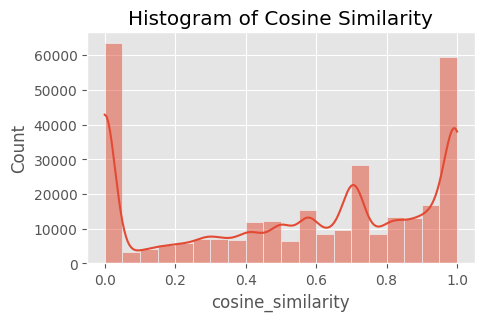

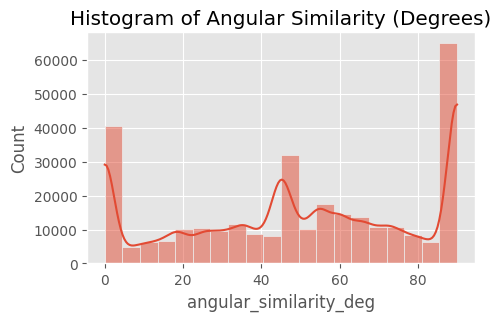

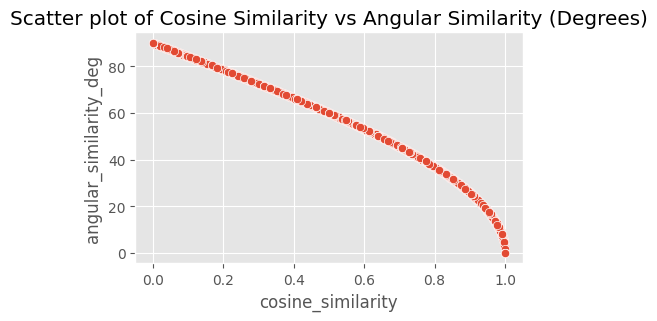

<ipython-input-12-783ff2cf66ad>:22: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data3.corr()


                        researcher_idx     time1     time2  cosine_similarity  \
researcher_idx                1.000000 -0.008251 -0.008251           0.000449   
time1                        -0.008251  1.000000  1.000000          -0.051652   
time2                        -0.008251  1.000000  1.000000          -0.051652   
cosine_similarity             0.000449 -0.051652 -0.051652           1.000000   
angular_similarity_deg       -0.000724  0.054006  0.054006          -0.973091   

                        angular_similarity_deg  
researcher_idx                       -0.000724  
time1                                 0.054006  
time2                                 0.054006  
cosine_similarity                    -0.973091  
angular_similarity_deg                1.000000  


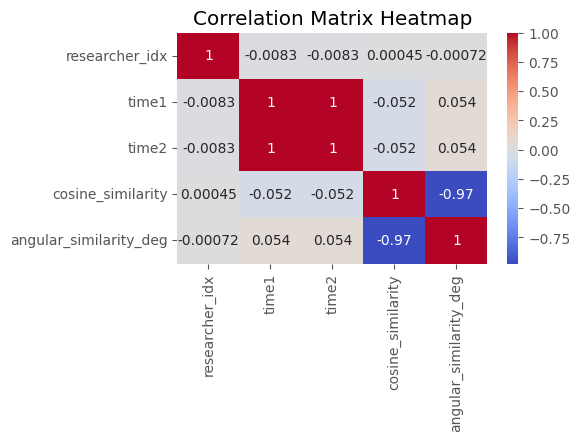

In [12]:
#@title Overview of the dataset

# Histogram for cosine_similarity
plt.figure(figsize=(5, 3))
sns.histplot(data=data3, x='cosine_similarity', bins=20, kde=True)
plt.title('Histogram of Cosine Similarity')
plt.show()

# Histogram for angular_similarity_deg
plt.figure(figsize=(5, 3))
sns.histplot(data=data3, x='angular_similarity_deg', bins=20, kde=True)
plt.title('Histogram of Angular Similarity (Degrees)')
plt.show()

# Scatter plot of cosine_similarity vs angular_similarity_deg
plt.figure(figsize=(5, 3))
sns.scatterplot(data=data3, x='cosine_similarity', y='angular_similarity_deg')
plt.title('Scatter plot of Cosine Similarity vs Angular Similarity (Degrees)')
plt.show()

# Compute the correlation matrix for all columns
correlation_matrix = data3.corr()
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Mean similarity by source organization
mean_similarity_by_source = data3.groupby('source_grid')[['cosine_similarity', 'angular_similarity_deg']].mean()
#print("Mean similarity by source organization:")
#print(mean_similarity_by_source)
#print('########################################################')
# Mean similarity by target organization
mean_similarity_by_target = data3.groupby('target_grid')[['cosine_similarity', 'angular_similarity_deg']].mean()
#print("Mean similarity by target organization:")
#print(mean_similarity_by_target)
#print('########################################################')

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


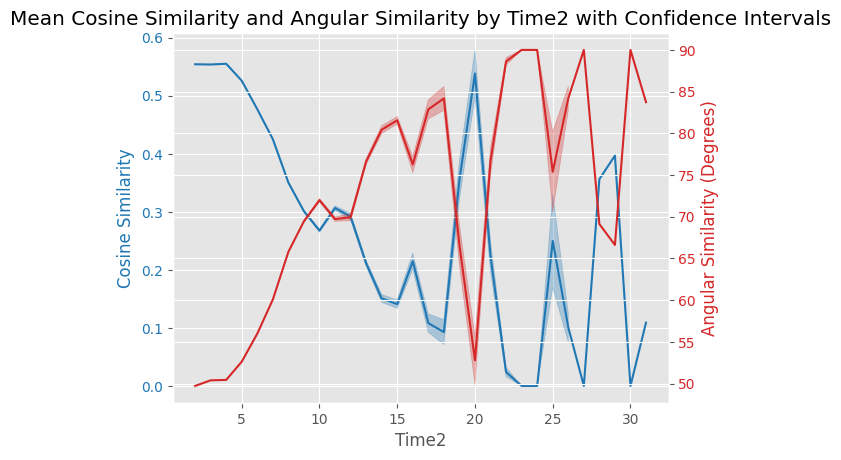

In [13]:
import seaborn as sns
from scipy.stats import sem, t

# Calculate the mean and SEM for each time2 value
summary_by_time2 = data3.groupby('time2')[['cosine_similarity', 'angular_similarity_deg']].agg(['mean', sem, 'count'])
summary_by_time2.columns = summary_by_time2.columns.map('_'.join)

# Calculate the confidence intervals
alpha = 0.95
z = t.ppf((1 + alpha) / 2, summary_by_time2['cosine_similarity_count'] - 1)
summary_by_time2['cosine_similarity_ci'] = z * summary_by_time2['cosine_similarity_sem'] / np.sqrt(summary_by_time2['cosine_similarity_count'])

z = t.ppf((1 + alpha) / 2, summary_by_time2['angular_similarity_deg_count'] - 1)
summary_by_time2['angular_similarity_deg_ci'] = z * summary_by_time2['angular_similarity_deg_sem'] / np.sqrt(summary_by_time2['angular_similarity_deg_count'])

# Plot the mean similarity by time2 with confidence intervals
fig, ax1 = plt.subplots()

# Plot cosine_similarity with time2
ax1.set_xlabel('Time2')
ax1.set_ylabel('Cosine Similarity', color='tab:blue')
ax1.plot(summary_by_time2.index, summary_by_time2['cosine_similarity_mean'], color='tab:blue')
ax1.fill_between(summary_by_time2.index,
                 summary_by_time2['cosine_similarity_mean'] - summary_by_time2['cosine_similarity_ci'],
                 summary_by_time2['cosine_similarity_mean'] + summary_by_time2['cosine_similarity_ci'],
                 color='tab:blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot angular_similarity_deg with time2
ax2 = ax1.twinx()
ax2.set_ylabel('Angular Similarity (Degrees)', color='tab:red')
ax2.plot(summary_by_time2.index, summary_by_time2['angular_similarity_deg_mean'], color='tab:red')
ax2.fill_between(summary_by_time2.index,
                 summary_by_time2['angular_similarity_deg_mean'] - summary_by_time2['angular_similarity_deg_ci'],
                 summary_by_time2['angular_similarity_deg_mean'] + summary_by_time2['angular_similarity_deg_ci'],
                 color='tab:red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title and show the plot
plt.title('Mean Cosine Similarity and Angular Similarity by Time2 with Confidence Intervals')
plt.show()

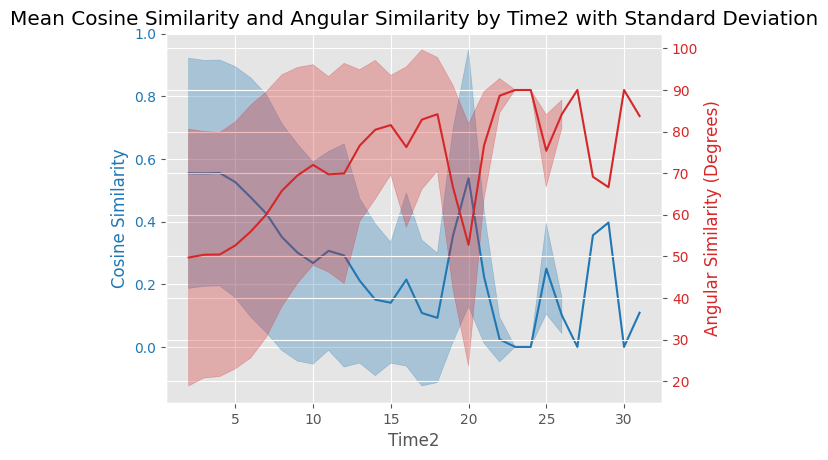

In [14]:
# Calculate the mean and standard deviation for each time2 value
summary_by_time2 = data3.groupby('time2')[['cosine_similarity', 'angular_similarity_deg']].agg(['mean', 'std'])
summary_by_time2.columns = summary_by_time2.columns.map('_'.join)

# Plot the mean similarity by time2 with standard deviation
fig, ax1 = plt.subplots()

# Plot cosine_similarity with time2
ax1.set_xlabel('Time2')
ax1.set_ylabel('Cosine Similarity', color='tab:blue')
ax1.plot(summary_by_time2.index, summary_by_time2['cosine_similarity_mean'], color='tab:blue')
ax1.fill_between(summary_by_time2.index,
                 summary_by_time2['cosine_similarity_mean'] - summary_by_time2['cosine_similarity_std'],
                 summary_by_time2['cosine_similarity_mean'] + summary_by_time2['cosine_similarity_std'],
                 color='tab:blue', alpha=0.3)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis to plot angular_similarity_deg with time2
ax2 = ax1.twinx()
ax2.set_ylabel('Angular Similarity (Degrees)', color='tab:red')
ax2.plot(summary_by_time2.index, summary_by_time2['angular_similarity_deg_mean'], color='tab:red')
ax2.fill_between(summary_by_time2.index,
                 summary_by_time2['angular_similarity_deg_mean'] - summary_by_time2['angular_similarity_deg_std'],
                 summary_by_time2['angular_similarity_deg_mean'] + summary_by_time2['angular_similarity_deg_std'],
                 color='tab:red', alpha=0.3)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Set the title and show the plot
plt.title('Mean Cosine Similarity and Angular Similarity by Time2 with Standard Deviation')
plt.show()


Let's investigate the data distribution by visualizing the distribution of similarity measures at different time2 values. This will provide insights into how the range of topics or research fields varies at different stages.

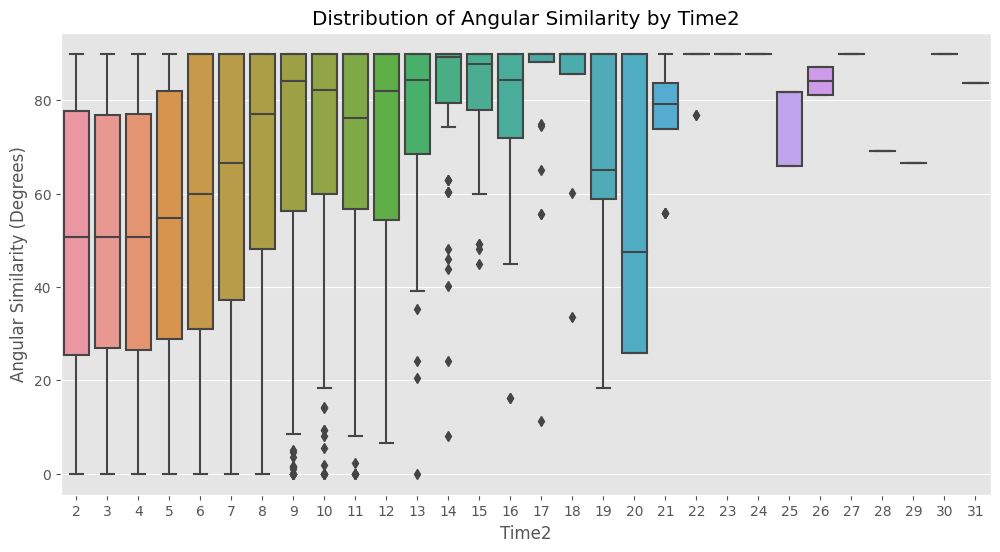

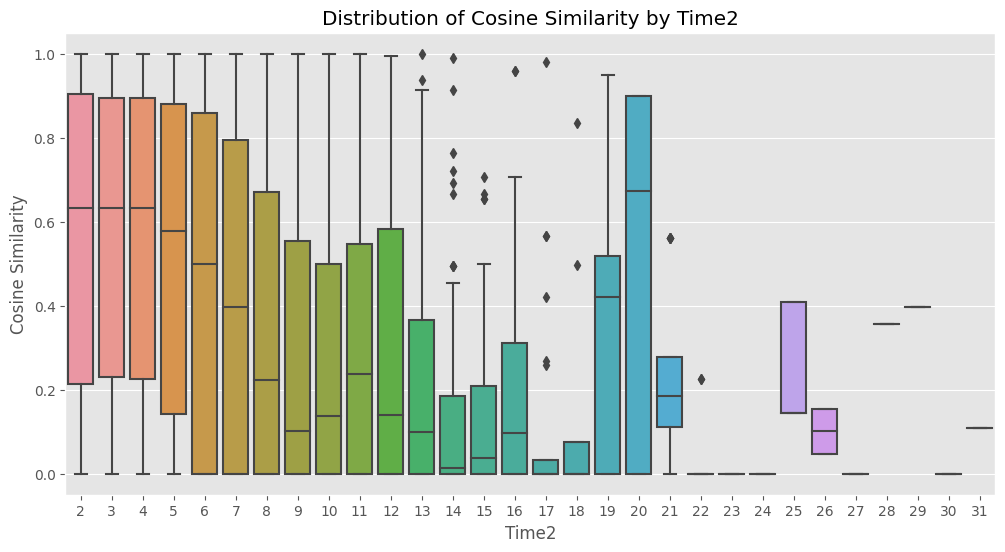

In [15]:
# Create box plots for cosine similarity at different time2 values
plt.figure(figsize=(12, 6))
sns.boxplot(x='time2', y='angular_similarity_deg', data=data3)

# Set the title and labels
plt.xlabel('Time2')
plt.ylabel('Angular Similarity (Degrees)')
plt.title('Distribution of Angular Similarity by Time2')

# Show the plot0
plt.show()

# Create box plots for cosine similarity at different time2 values
plt.figure(figsize=(12, 6))
sns.boxplot(x='time2', y='cosine_similarity', data=data3)

# Set the title and labels
plt.xlabel('Time2')
plt.ylabel('Cosine Similarity')
plt.title('Distribution of Cosine Similarity by Time2')

# Show the plot0
plt.show()

In [16]:
#@title Analysis of transformation
import scipy.stats as st

################################### Overall #####################################

# 1. Calculate the mean angular similarity for each target_grid over time2
overall_mean_similarity_df_six_plus_merged = data3.groupby(['target_grid'])['angular_similarity_deg'].mean().reset_index()

# 2. Calculate the standard deviation of the mean
overall_std_similarity_df_six_plus_merged = data3.groupby(['target_grid'])['angular_similarity_deg'].std().reset_index()

# 3. Calculate the confidence intervals of the mean
# Get the number of data points for each group
overall_count_similarity_df_six_plus_merged = data3.groupby(['target_grid']).size().reset_index(name='count')

# Calculate the standard error of the mean
overall_count_similarity_df_six_plus_merged['sem'] = overall_std_similarity_df_six_plus_merged['angular_similarity_deg'] / np.sqrt(overall_count_similarity_df_six_plus_merged['count'])

# Calculate the confidence intervals (95%)
alpha = 0.95
z_score = st.norm.ppf((1 + alpha) / 2)
overall_count_similarity_df_six_plus_merged['ci_lower'] = overall_mean_similarity_df_six_plus_merged['angular_similarity_deg'] - z_score * overall_count_similarity_df_six_plus_merged['sem']
overall_count_similarity_df_six_plus_merged['ci_upper'] = overall_mean_similarity_df_six_plus_merged['angular_similarity_deg'] + z_score * overall_count_similarity_df_six_plus_merged['sem']

# Merge the results
overall_results_similarity_df_six_plus = pd.concat([overall_mean_similarity_df_six_plus_merged
                        , overall_std_similarity_df_six_plus_merged['angular_similarity_deg']
                        , overall_count_similarity_df_six_plus_merged[['count', 'sem', 'ci_lower', 'ci_upper']]]
                        , axis=1)

overall_results_similarity_df_six_plus.columns = ['target_grid', 'mean', 'std', 'count', 'sem', 'ci_lower', 'ci_upper']

# Print the results
overall_results_similarity_df_six_plus.head(10)


,target_grid,mean,std,count,sem,ci_lower,ci_upper
0,grid.1001.0,53.636619,28.873952,160,2.282686,49.162636,58.110602
1,grid.1002.3,48.650499,32.492646,471,1.497182,45.716076,51.584922
2,grid.10025.36,50.049519,30.995012,170,2.377209,45.390275,54.708763
3,grid.1003.2,52.104449,30.423588,455,1.426280,49.308992,54.899906
4,grid.1004.5,49.767591,33.043826,113,3.108502,43.675039,55.860142
5,grid.10041.34,47.895296,28.330842,40,4.479499,39.115638,56.674953
6,grid.10049.3c,54.323690,29.335477,71,3.481481,47.500114,61.147267
7,grid.1005.4,48.073236,31.703396,461,1.476574,45.179203,50.967269
8,grid.1006.7,50.129952,31.038691,112,2.932881,44.381611,55.878292
9,grid.10067.30,46.694518,29.935150,14,8.000505,31.013816,62.375221


**Descriptive statistics and visualization of the summary data**

       researcher_idx          time1          time2  cosine_similarity  \
count   306875.000000  306875.000000  306875.000000      306875.000000   
mean    338551.520867       1.496443       2.496443           0.550970   
std     198201.082446       1.086619       1.086619           0.366269   
min          0.000000       1.000000       2.000000           0.000000   
25%     166037.000000       1.000000       2.000000           0.208232   
50%     334481.000000       1.000000       2.000000           0.632456   
75%     519838.500000       2.000000       3.000000           0.899229   
max     679346.000000      30.000000      31.000000           1.000000   

       angular_similarity_deg  
count           305842.000000  
mean                50.178420  
std                 30.512231  
min                  0.000000  
25%                 26.565051  
50%                 50.954246  
75%                 78.221768  
max                 90.000000  
#######################


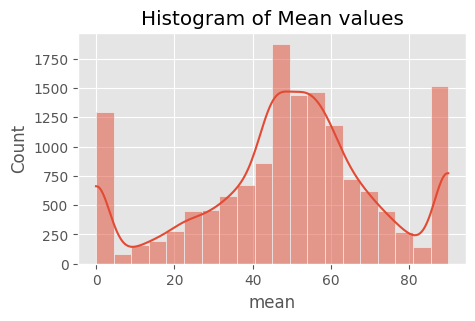

#######################


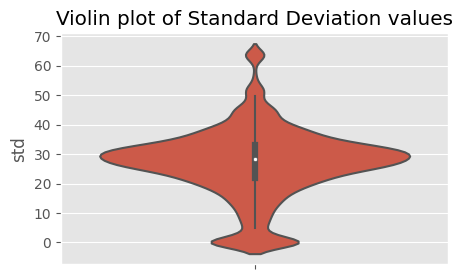

#######################
              mean       std     count       sem  ci_lower  ci_upper
mean      1.000000 -0.086260  0.008884 -0.087021  0.770575  0.718935
std      -0.086260  1.000000  0.053592  0.705594 -0.513090  0.425057
count     0.008884  0.053592  1.000000 -0.223041  0.148914 -0.148840
sem      -0.087021  0.705594 -0.223041  1.000000 -0.701988  0.629877
ci_lower  0.770575 -0.513090  0.148914 -0.701988  1.000000  0.110987
ci_upper  0.718935  0.425057 -0.148840  0.629877  0.110987  1.000000


<ipython-input-17-5062ff923f08>:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = overall_results_similarity_df_six_plus.corr()


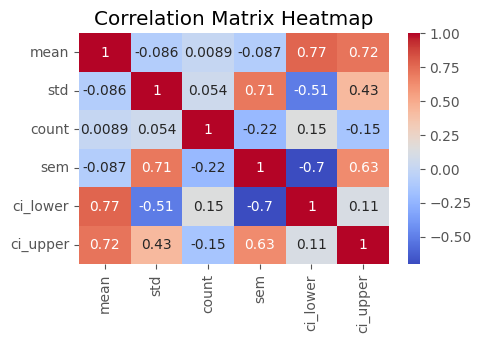

In [17]:
summary = data3.describe()
print(summary)
print('#######################')

# Histogram for the mean column
plt.figure(figsize=(5, 3))
sns.histplot(data=overall_results_similarity_df_six_plus, x='mean', bins=20, kde=True)
plt.title('Histogram of Mean values')
plt.show()
print('#######################')

# Violin plot for the standard deviation column
plt.figure(figsize=(5, 3))
sns.violinplot(data=overall_results_similarity_df_six_plus, y='std')
plt.title('Violin plot of Standard Deviation values')
plt.show()
print('#######################')

# Compute the correlation matrix for all columns
correlation_matrix = overall_results_similarity_df_six_plus.corr()
print(correlation_matrix)
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

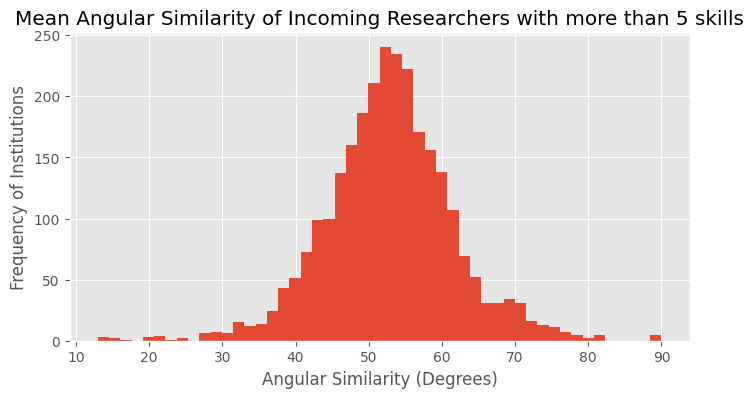

In [21]:
# make the dataset more maneagable by filtering out all sources and grids which are not at the top 1000 organisations ranked by TNCS

ranks_six_plus = overall_results_similarity_df_six_plus.merge(grid_ranks, left_on='target_grid', right_on='grid_id', how='inner')

# Reset the index
ranks_six_plus.reset_index(drop=True, inplace=True)

# Drop duplicates
ranks_six_plus.drop_duplicates(inplace=True)

# Sort the merged DataFrame by 'pp_top_10_prop' in ascending order
sorted_ranks_six_plus = ranks_six_plus.astype({'pp_top_10_prop': float}).sort_values(by='pp_top_10_prop', ascending=False)

# Filter the top 1000 rows
top_10000_rows = sorted_ranks_six_plus.head(10000)

top_10000_rows.head(5)

# plot a histogram distribution for each researcher_id
plt.figure(figsize=(8, 4))
plt.hist(top_10000_rows['mean'], bins=50)  
plt.title("Mean Angular Similarity of Incoming Researchers with more than 5 skills")
plt.xlabel("Angular Similarity (Degrees)")
plt.ylabel("Frequency of Institutions")
plt.show()

<ipython-input-22-f0753fd3ee00>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_top_1000 = top_10000_rows.corr()


                     mean       std     count       sem  ci_lower  ci_upper  \
mean             1.000000 -0.314085 -0.110465  0.012697  0.792714  0.798362   
std             -0.314085  1.000000  0.067274  0.319828 -0.446392 -0.055743   
count           -0.110465  0.067274  1.000000 -0.409428  0.162031 -0.333077   
sem              0.012697  0.319828 -0.409428  1.000000 -0.599480  0.612266   
ci_lower         0.792714 -0.446392  0.162031 -0.599480  1.000000  0.265788   
ci_upper         0.798362 -0.055743 -0.333077  0.612266  0.265788  1.000000   
for_division_id       NaN       NaN       NaN       NaN       NaN       NaN   
p_fractional    -0.029374  0.056969  0.696100 -0.395376  0.218589 -0.260283   
tcs             -0.028133  0.065603  0.713008 -0.366296  0.201893 -0.241749   
mcs             -0.037401  0.078472  0.342111 -0.369704  0.198867 -0.248844   
tncs            -0.034155  0.078525  0.721844 -0.382076  0.206742 -0.255965   
mncs            -0.060054  0.149592  0.304254 -0.314

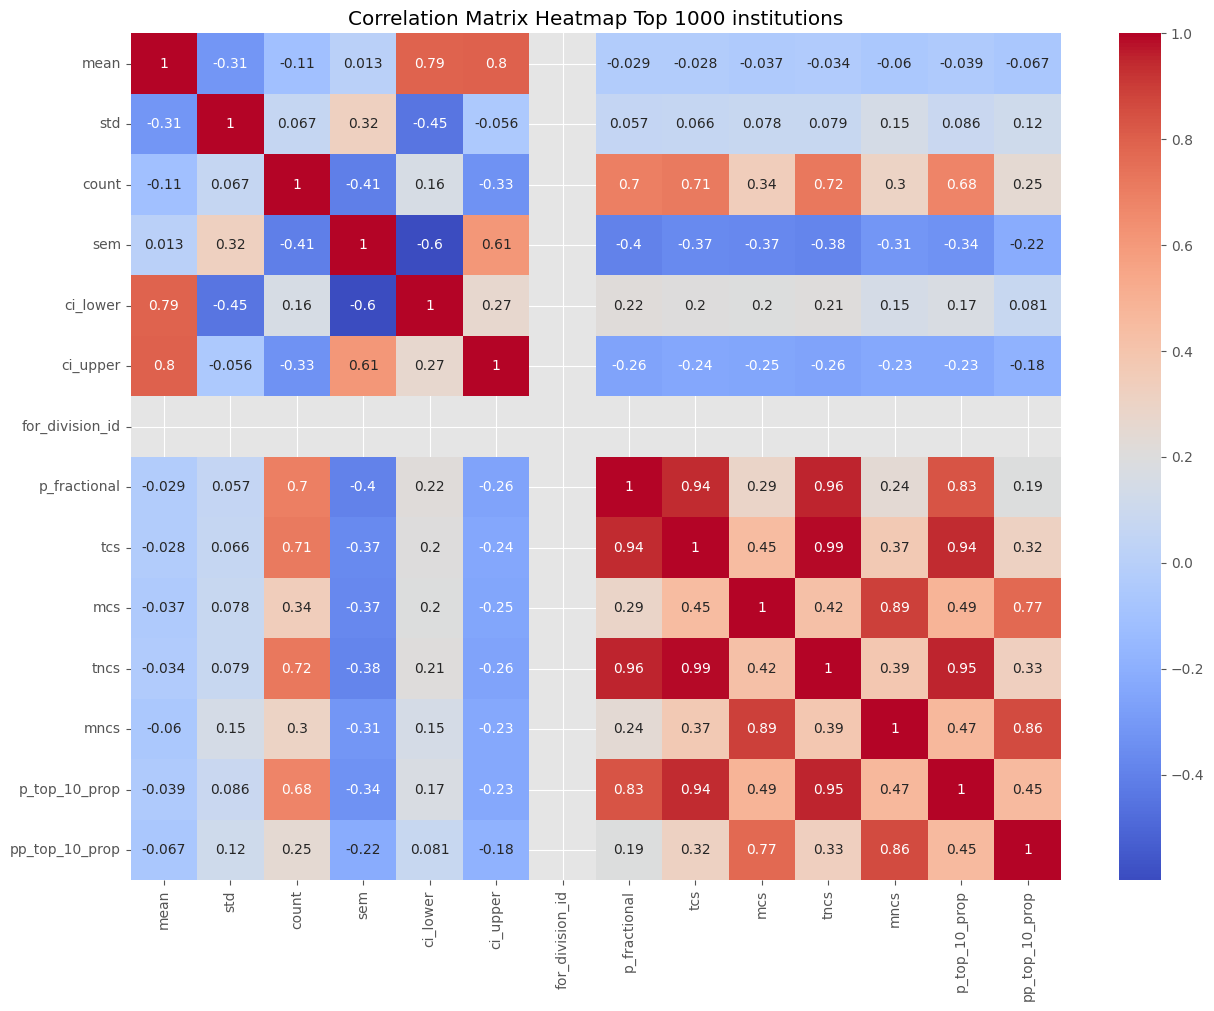

In [22]:
# Compute the correlation matrix for all columns
correlation_matrix_top_1000 = top_10000_rows.corr()
print(correlation_matrix_top_1000)
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(15, 11))
sns.heatmap(correlation_matrix_top_1000, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap Top 1000 institutions')
plt.show()

## Top 10000

<ipython-input-24-a352d19322f7>:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


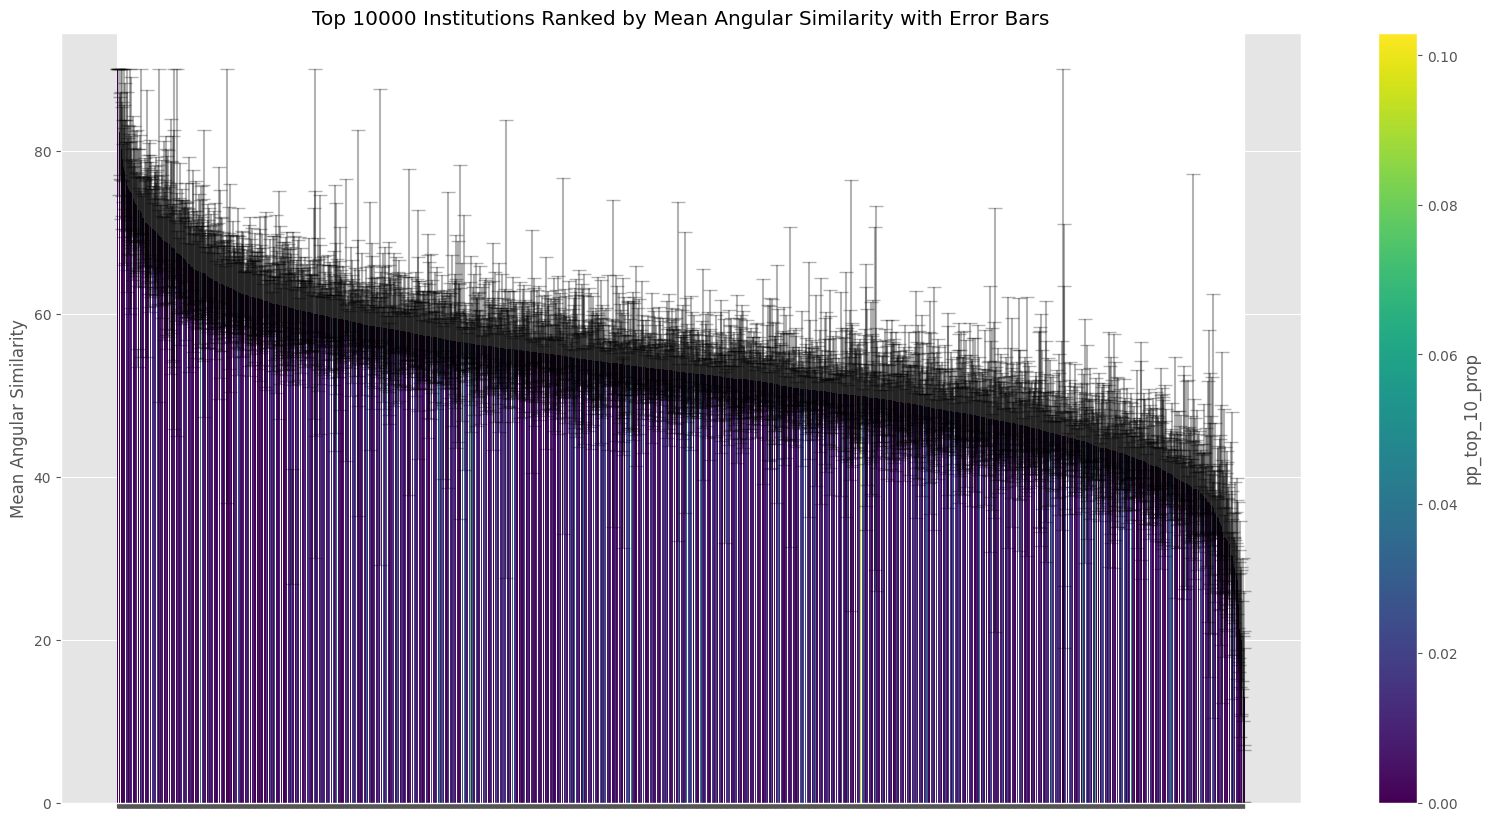

In [24]:
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Sort the dataframe by the mean in descending order and select the top 100
top_10000_rows = top_10000_rows.sort_values(by='mean', ascending=False).head(10000)

# Normalize the tncs values for color mapping
norm = plt.Normalize(top_10000_rows['pp_top_10_prop'].min(), top_10000_rows['pp_top_10_prop'].max())
colors = cm.viridis(norm(top_10000_rows['pp_top_10_prop']))

# Create a bar chart with the institution names on the x-axis and the mean on the y-axis, adding error bars using the standard error of the mean (sem)
plt.figure(figsize=(20, 10))
bars = plt.bar(top_10000_rows['organization_name']
               , top_10000_rows['mean']
               , yerr=top_10000_rows['sem']
               , capsize=5
               , color=colors
               , ecolor=(0, 0, 0, 0.3))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)
# plt.xlabel('Institution Name')  # Comment out or remove this line to remove the x-axis label
plt.ylabel('Mean Angular Similarity')
plt.title('Top 10000 Institutions Ranked by Mean Angular Similarity with Error Bars')

# Clear xticks labels
plt.gca().set_xticklabels([])

# Create a colorbar based on the tncs values
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('pp_top_10_prop')

plt.show()


<ipython-input-36-cc2e12ff57a1>:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


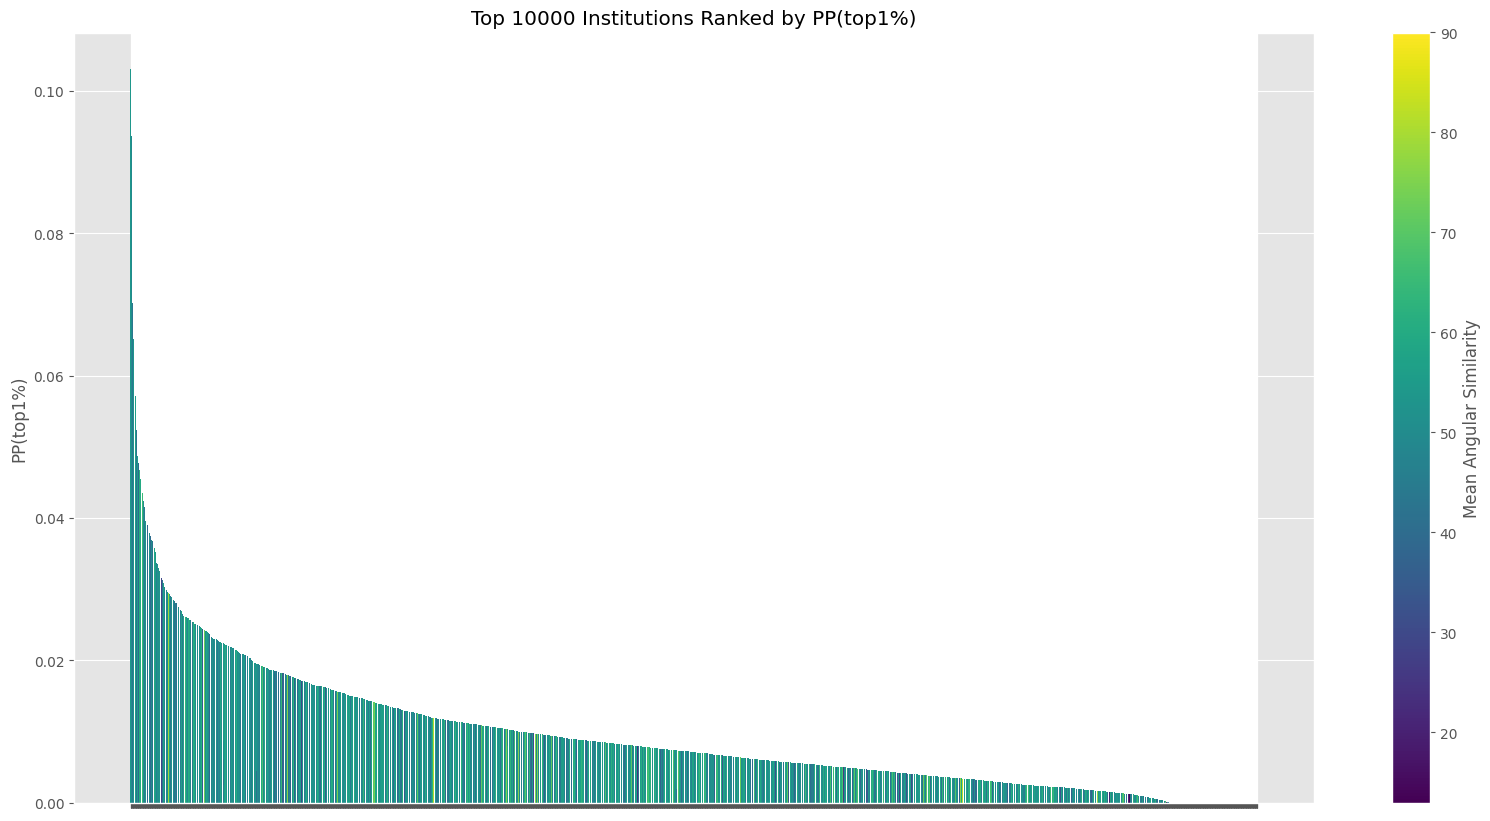

In [36]:
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

# Sort the dataframe by the mean in descending order and select the top 100
top_10000_rows = top_10000_rows.sort_values(by='pp_top_10_prop', ascending=False).head(10000)

# Normalize the tncs values for color mapping
norm = plt.Normalize(top_10000_rows['mean'].min(), top_10000_rows['mean'].max())
colors = cm.viridis(norm(top_10000_rows['mean']))

# Create a bar chart with the institution names on the x-axis and the mean on the y-axis, adding error bars using the standard error of the mean (sem)
plt.figure(figsize=(20, 10))
bars = plt.bar(top_10000_rows['organization_name']
               , top_10000_rows['pp_top_10_prop']
               , color=colors)

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)
# plt.xlabel('Institution Name')  # Comment out or remove this line to remove the x-axis label
plt.ylabel('PP(top1%)')
plt.title('Top 10000 Institutions Ranked by PP(top1%)')

# Clear xticks labels
plt.gca().set_xticklabels([])

# Create a colorbar based on the tncs values
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Mean Angular Similarity')

plt.show()

## Top 100

<ipython-input-30-2769e8fb2fc8>:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


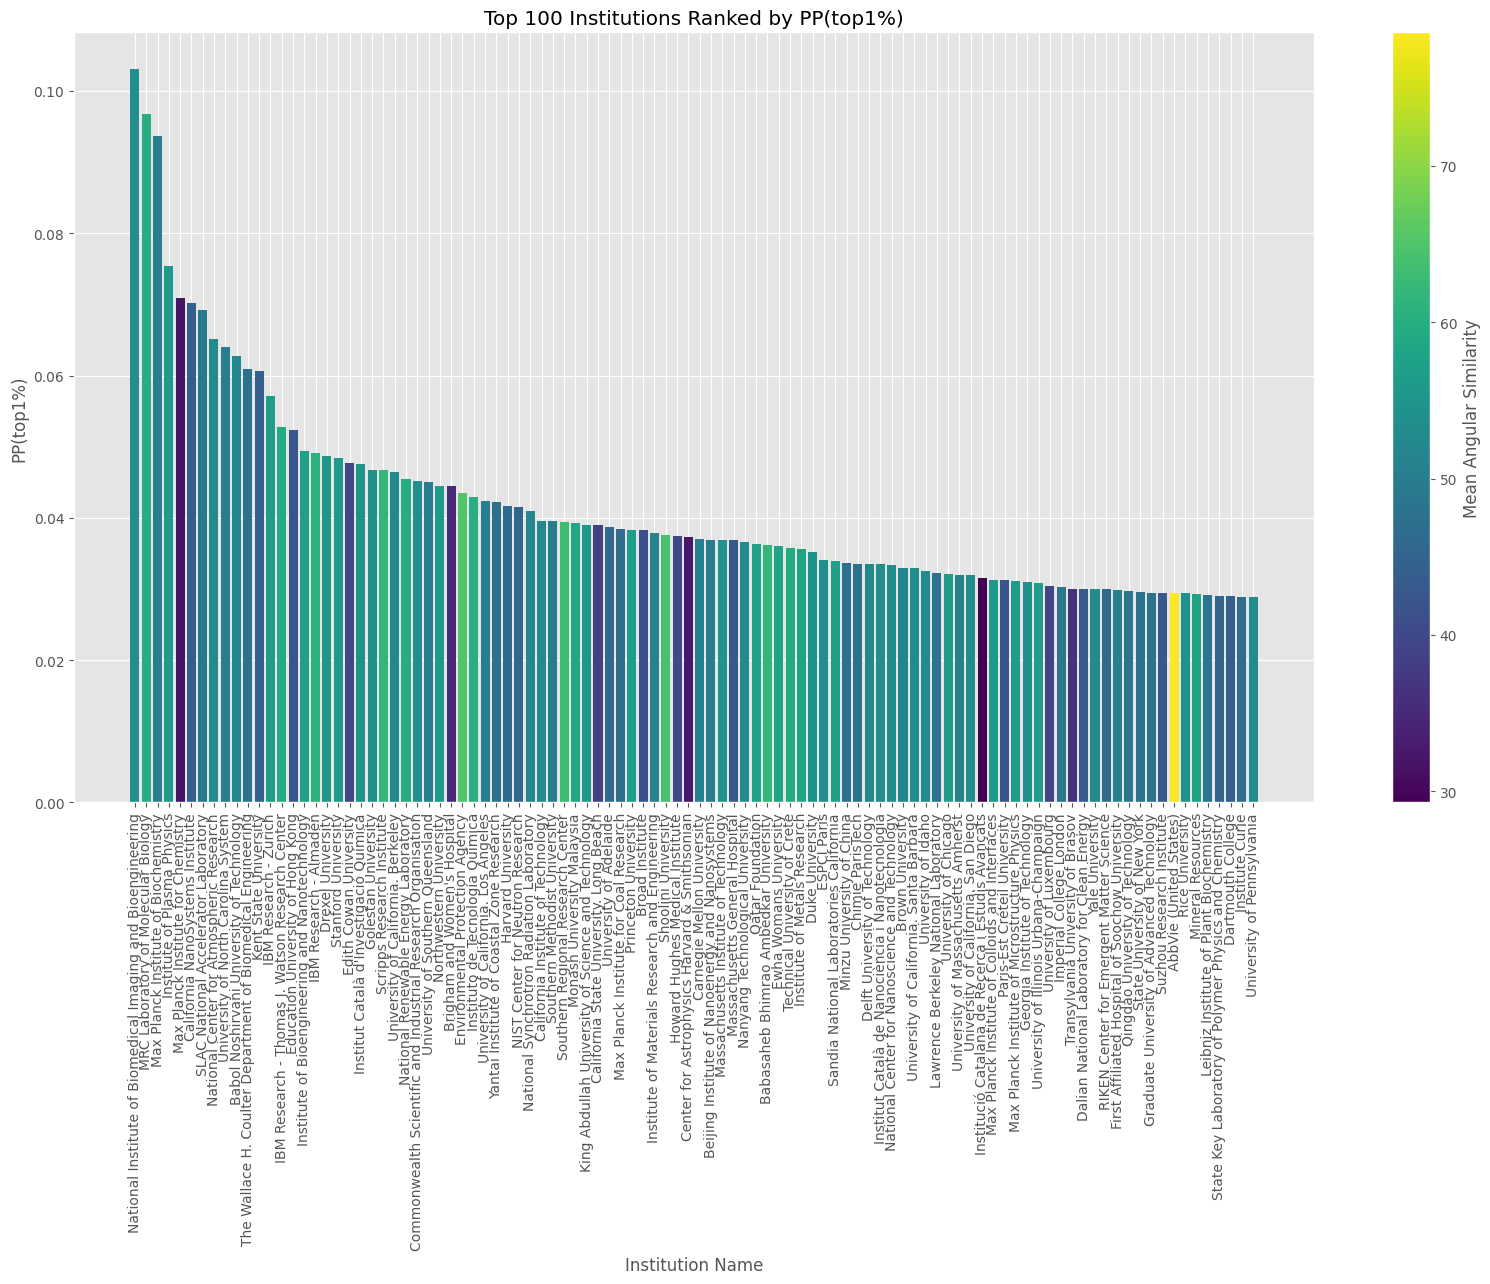

In [30]:
# Sort the dataframe by the mean in descending order and select the top 100
top_100_institutions = top_10000_rows.sort_values(by='pp_top_10_prop', ascending=False).head(100)

# Normalize the tncs values for color mapping
norm = plt.Normalize(top_100_institutions['mean'].min(), top_100_institutions['mean'].max())
colors = cm.viridis(norm(top_100_institutions['mean']))

# Create a bar chart with the institution names on the x-axis and the mean on the y-axis, adding error bars using the standard error of the mean (sem)
plt.figure(figsize=(20, 10))
bars = plt.bar(top_100_institutions['organization_name'], top_100_institutions['pp_top_10_prop'],  capsize=5, color=colors, ecolor=(0, 0, 0, 0.3))

# Rotate the x-axis labels vertically
plt.xticks(rotation=90)
plt.xlabel('Institution Name')
plt.ylabel('PP(top1%)')
plt.title('Top 100 Institutions Ranked by PP(top1%)')

# Create a colorbar based on the tncs values
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Mean Angular Similarity')

plt.show()

**Analyze the change potential of researchers over time by comparing the means and confidence intervals across different time periods.**

In [40]:
import plotly.graph_objs as go

# Create a scatter plot with the institution names on the x-axis and the mean on the y-axis, with marker size based on the number of papers (p)
fig = go.Figure(data=go.Scatter(
    x=top_10000_rows['pp_top_10_prop'],
    y=top_10000_rows['mean'],
    mode='markers',
    marker=dict(
        size=top_10000_rows['count'],
        sizemode='area',
        sizeref=0.5,
        sizemin=0.2,
        color=top_10000_rows['pp_top_10_prop'],
        colorbar=dict(title='pp_top_10_prop'),
        colorscale='viridis',
        showscale=True,
    ),
    text=top_10000_rows['organization_name']
))


# Add axis labels and title
fig.update_layout(
    xaxis_title="PP(top1%)",
    yaxis_title="Mean Angular Similarity",
    title="Top 10000 Institutions Ranked by Mean Angular Similarity with Marker Size Based on Inflows"
)

# Rotate x-axis labels vertically
fig.update_xaxes(tickangle=-90)

# Show hover text with institution name
fig.update_traces(hovertemplate='<b>%{text}</b><br>PP(top1%): %{x:.2f}<br>Mean Angular Similarity: %{y:.2f}<br>Count: %{marker.size}')

# Show the plot
fig.show()


In [41]:
import plotly.graph_objs as go

# Create a scatter plot with the institution names on the x-axis and the mean on the y-axis, with marker size based on the number of papers (p)
fig = go.Figure(data=go.Scatter(
    x=top_100_institutions['pp_top_10_prop'],
    y=top_100_institutions['mean'],
    mode='markers',
    marker=dict(
        size=top_100_institutions['count'],
        sizemode='area',
        sizeref=0.5,
        sizemin=0.2,
        color=top_100_institutions['pp_top_10_prop'],
        colorbar=dict(title='pp_top_10_prop'),
        colorscale='viridis',
        showscale=True,
    ),
    text=top_100_institutions['organization_name']
))


# Add axis labels and title
fig.update_layout(
    xaxis_title="PP(top1%)",
    yaxis_title="Mean Angular Similarity",
    title="Top 100 Institutions Ranked by Mean Angular Similarity with Marker Size Based on Inflows"
)

# Rotate x-axis labels vertically
fig.update_xaxes(tickangle=-90)

# Show hover text with institution name
fig.update_traces(hovertemplate='<b>%{text}</b><br>PP(top1%): %{x:.2f}<br>Mean Angular Similarity: %{y:.2f}<br>Count: %{marker.size}')

# Show the plot
fig.show()

In [42]:
import plotly.graph_objs as go

# Create a scatter plot with the institution names on the x-axis and the mean on the y-axis, with marker size based on the number of papers (p)
fig = go.Figure(data=go.Scatter(
    x=top_10000_rows['pp_top_10_prop'],
    y=top_10000_rows['mean'],
    mode='markers',
    text=top_10000_rows['organization_name']
))


# Add axis labels and title
fig.update_layout(
    xaxis_title="PP(top1%)",
    yaxis_title="Mean Angular Similarity",
    title="Top 100 Institutions Ranked by Mean Angular Similarity with Marker Size Based on Number of Papers and Error Bars"
)

# Rotate x-axis labels vertically
fig.update_xaxes(tickangle=-90)

# Show hover text with institution name
fig.update_traces(hovertemplate='<b>%{text}</b><br>PP(top1%): %{x:.2f}<br>Mean Angular Similarity: %{y:.2f}<br>Count: %{marker.size}')

# Show the plot
fig.show()


**Explore the relationship between the source institution and the change potential.**

### Org Ranks vs Transformation index


# Next steps
* Aggregate angle scores to the institutional level
* plot ranks against angles, limit to top 100 organisations
* Plot the data and send it to Stefan and Vito



# Visualizations

In [ ]:
import plotly.graph_objects as go
import plotly.subplots as sp

def create_filtered_summary_stats(df):
    summary_stats_change = df.groupby('time1')['cosine_similarity'].agg(['mean', 'median', 'count']).reset_index()
    summary_stats_change.columns = ['num_changes', 'average_similarity', 'median_similarity', 'num_researchers']
    summary_stats_change_filtered = summary_stats_change[summary_stats_change['num_researchers'] > 50]
    return summary_stats_change_filtered

# Filter and summarize the three dataframes
summary_stats_change_filtered1 = create_filtered_summary_stats(similarity_df_six_plus)
summary_stats_change_filtered2 = create_filtered_summary_stats(similarity_df_four_five)
summary_stats_change_filtered3 = create_filtered_summary_stats(similarity_df_two_three)

# Create a subplot with 3 columns
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=("similarity_df_six_plus", "similarity_df_four_five", "similarity_df_two_three"))

# Add line plots for each dataset
for i, summary_stats in enumerate([summary_stats_change_filtered1, summary_stats_change_filtered2, summary_stats_change_filtered3]):
    # Add line plot for average similarity
    fig.add_trace(go.Scatter(x=summary_stats['num_changes'],
                             y=summary_stats['average_similarity'],
                             mode='lines+markers',
                             name=f'Average Similarity {i+1}',
                             marker=dict(size=summary_stats['num_researchers'],
                                         sizemode='area',
                                         sizeref=2.*max(summary_stats['num_researchers'])/(40.**2),
                                         sizemin=4)), row=1, col=i+1)
    
    # Add line plot for median similarity
    fig.add_trace(go.Scatter(x=summary_stats['num_changes'],
                             y=summary_stats['median_similarity'],
                             mode='lines+markers',
                             name=f'Median Similarity {i+1}',
                             marker=dict(size=summary_stats['num_researchers'],
                                         sizemode='area',
                                         sizeref=2.*max(summary_stats['num_researchers'])/(40.**2),
                                         sizemin=4)), row=1, col=i+1)
    
# Update layout and axis titles
fig.update_layout(title='Medical and Health Science (FOR=11) Average Similarity by Number of Changes for Three Datasets',template='plotly_dark')

fig.update_xaxes(title_text='Number of changes', row=1, col=1)
fig.update_xaxes(title_text='Number of changes', row=1, col=2)
fig.update_xaxes(title_text='Number of changes', row=1, col=3)

fig.update_yaxes(title_text='Cosine Similarity', row=1, col=1)
fig.update_yaxes(title_text='Cosine Similarity', row=1, col=2)
fig.update_yaxes(title_text='Cosine Similarity', row=1, col=3)

fig.show()

# Create a subplot with 3 columns for boxplots
fig_box = sp.make_subplots(rows=1, cols=3, subplot_titles=("Dataset 1", "Dataset 2", "Dataset 3"))

# Add box plots for each dataset
datasets = [similarity_df_six_plus, similarity_df_four_five, similarity_df_two_three]
filtered_summaries = [summary_stats_change_filtered1, summary_stats_change_filtered2, summary_stats_change_filtered3]

for col, (dataset, summary) in enumerate(zip(datasets, filtered_summaries), start=1):
    data_to_plot = [dataset[dataset['time1'] == x]['cosine_similarity'].tolist() for x in summary['num_changes']]
    labels = [str(x) for x in summary['num_changes'].values]
    
    for data, label in zip(data_to_plot, labels):
        fig_box.add_trace(go.Box(y=data, name=label, showlegend=False), row=1, col=col)

# Update layout and axis titles
fig_box.update_layout(title='Boxplot of Average Similarity by Number of Changes for Three Datasets',
                      template='plotly_dark')

fig_box.update_xaxes(title_text='Number of changes', row=1, col=1)
fig_box.update_xaxes(title_text='Number of changes', row=1, col=2)
fig_box.update_xaxes(title_text='Number of changes', row=1, col=3)

fig_box.update_yaxes(title_text='Average Cosine Similarity', row=1, col=1)
fig_box.update_yaxes(title_text='Average Cosine Similarity', row=1, col=2)
fig_box.update_yaxes(title_text='Average Cosine Similarity', row=1, col=3)

fig_box.show()

REDO THIS PLOT


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 1. Define a function to categorize researchers based on their average_similarity
def categorize_researcher(avg_similarity, num_groups=4):
    if avg_similarity <= 0.25:
        return 1
    elif avg_similarity <= 0.5:
        return 2
    elif avg_similarity <= 0.75:
        return 3
    else:
        return 4

# Calculate the average cosine similarity change and the number of changes for each researcher
researcher_means = similarity_df_six_plus.groupby('researcher_id')['cosine_similarity'].agg(['mean', 'count']).reset_index()
researcher_means.columns = ['researcher_id', 'average_similarity', 'num_changes']

# Display the summary statistics
print(researcher_means)

print('###################################################################')

print(researcher_means.sort_values(by='num_changes'))

# 2. Apply the function to the summary_stats DataFrame to create a new column `group`
researcher_means['group'] = researcher_means['average_similarity'].apply(categorize_researcher)

print(researcher_means.head(10))
# 3. Merge the `group` information into the `similarity_df` DataFrame
similarity_df = pd.merge(similarity_df_six_plus, researcher_means[['researcher_id', 'group']], on='researcher_id')

# 4. Aggregate cosine similarity values for each group and time period
grouped_data = similarity_df.groupby(['group', 'time2'])['cosine_similarity'].agg(['mean', 'std', 'count']).reset_index()

# 5. Calculate the confidence intervals
alpha = 0.95
grouped_data['conf_interval'] = grouped_data.apply(lambda row: stats.t.ppf((1 + alpha) / 2, row['count'] - 1) * row['std'] / np.sqrt(row['count']), axis=1)

# 6. Create a line plot with confidence intervals around the lines for each group over time
fig, ax = plt.subplots()

for group_id, group_data in grouped_data.groupby('group'):
    ax.plot(group_data['time2'], group_data['mean'], label=f'Group {group_id}')
    ax.fill_between(group_data['time2'], group_data['mean'] - group_data['conf_interval'], group_data['mean'] + group_data['conf_interval'], alpha=0.2)

ax.set_xlabel('Time')
ax.set_ylabel('Cosine Similarity')
ax.legend(loc='best')

plt.show()


In [ ]:
# boxplot by group
# Assuming your DataFrame is named 'df'
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
ax = sns.boxplot(x='group', y='cosine_similarity', data=similarity_df, palette='coolwarm')
ax.set_title('Boxplot of Cosine Similarity Scores by Group', fontsize=16, pad=20)
ax.set_xlabel('Group', fontsize=14)
ax.set_ylabel('Cosine Similarity', fontsize=14)
ax.tick_params(axis='both', labelsize=12)

# Display the boxplot
plt.show()

In [ ]:
similarity_df.head(10).sort_values(by='researcher_id')

**It looks like lower similarity groups are associated with less affiliation changes**
- make the same vizualization but for number of changes and see if they agree
- check academic age effects
- check for prestige effects
- make ranking of institutions by the four fields based on the cosine
- check how scholars change their profile over time regardless of changing behaviour
